<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследование-поведения-пользователей-мобильного-приложения-продажи-продуктов-питания" data-toc-modified-id="Исследование-поведения-пользователей-мобильного-приложения-продажи-продуктов-питания-1">Исследование поведения пользователей мобильного приложения продажи продуктов питания</a></span><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1.1">Описание проекта</a></span><ul class="toc-item"><li><span><a href="#Задачи" data-toc-modified-id="Задачи-1.1.1">Задачи</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1.1.2">Описание данных</a></span></li><li><span><a href="#План-работы" data-toc-modified-id="План-работы-1.1.3">План работы</a></span></li></ul></li><li><span><a href="#Загрузка-данных-и-подготовка-их-к-анализу" data-toc-modified-id="Загрузка-данных-и-подготовка-их-к-анализу-1.2">Загрузка данных и подготовка их к анализу</a></span><ul class="toc-item"><li><span><a href="#Итоги-предобработки" data-toc-modified-id="Итоги-предобработки-1.2.1">Итоги предобработки</a></span></li></ul></li><li><span><a href="#Изучение-и-проверка-данных" data-toc-modified-id="Изучение-и-проверка-данных-1.3">Изучение и проверка данных</a></span><ul class="toc-item"><li><span><a href="#Итоги-проверки-данных" data-toc-modified-id="Итоги-проверки-данных-1.3.1">Итоги проверки данных</a></span></li></ul></li><li><span><a href="#Изучение-воронки-событий" data-toc-modified-id="Изучение-воронки-событий-1.4">Изучение воронки событий</a></span><ul class="toc-item"><li><span><a href="#Результаты-воронки-событий" data-toc-modified-id="Результаты-воронки-событий-1.4.1">Результаты воронки событий</a></span></li></ul></li><li><span><a href="#Изучение-результатов-эксперимента" data-toc-modified-id="Изучение-результатов-эксперимента-1.5">Изучение результатов эксперимента</a></span><ul class="toc-item"><li><span><a href="#Результаты-эксперимента" data-toc-modified-id="Результаты-эксперимента-1.5.1">Результаты эксперимента</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-1.6">Выводы</a></span></li></ul></li></ul></div>

# Исследование поведения пользователей мобильного приложения продажи продуктов питания

## Описание проекта
Нужно разобраться, как ведут себя пользователи мобильного приложения стартапа, который продаёт продукты питания.

### Задачи
* Изучить воронку продаж
* Исследовать результаты A/A/B-эксперимента

### Описание данных
Датасет: `/datasets/logs_exp.csv`. Каждая запись в логе — это действие пользователя, или событие. Структура:
* `EventName` — название события;
* `DeviceIDHash` — уникальный идентификатор пользователя;
* `EventTimestamp` — время события;
* `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

### План работы
1. Загрузка данных
2. Подготовка данных к анализу
3. Изучение и проверка данных
4. Изучение воронки событий
5. Изучение результатов эксперимента
6. Выводы

## Загрузка данных и подготовка их к анализу

In [1]:
# импорт библиотек
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math as mth

In [2]:
# загружаю данные
data = pd.read_csv('logs_exp.csv', sep='\t')
data.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [3]:
# меняю названия столбцов
data.columns = ['event', 'user_id', 'event_time', 'group']

In [4]:
# проверяю пропуски и типы данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event       244126 non-null  object
 1   user_id     244126 non-null  int64 
 2   event_time  244126 non-null  int64 
 3   group       244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
# меняю типы данных
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')

In [6]:
# добавляю отдельный столбец с датой
data['date'] = pd.to_datetime(data['event_time'].dt.date)

In [7]:
# проверяю наличие дубликатов
data.duplicated().sum()

413

In [8]:
# удаляю дубликаты
data = data.drop_duplicates().reset_index(drop=True)

In [9]:
# проверка на попадание одного человека в разные группы
data.groupby('user_id')['group'].nunique().reset_index().query('group > 1')

,user_id,group


### Итоги предобработки
В результате предобработки данных в столбцах с датой типы были преобразованы в соответствии с сохраненными в них значениями, столбцы переименованы для удобства, пропуски не обнаружены, пользователи распределены по трем группам без пересечений. 413 (менее 0.2%) записей дублировались и были удалены.

## Изучение и проверка данных

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event, dtype: int64

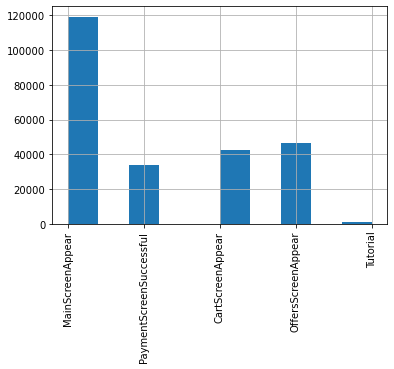

In [10]:
# проверяю, сколько событий в логе и как они распределены
data['event'].hist(xrot=90, bins=10)
data['event'].value_counts()

In [11]:
# проверяю, сколько всего пользователей в логе
row_ucer_cnt = data['user_id'].nunique()
row_ucer_cnt

7551

In [12]:
# проверяю, сколько в среднем событий приходится на пользователя
round((data.groupby('user_id')['event'].count()).mean(), 2)

32.28

Timestamp('2019-07-25 04:43:36')

Timestamp('2019-08-07 21:15:17')

<AxesSubplot:>

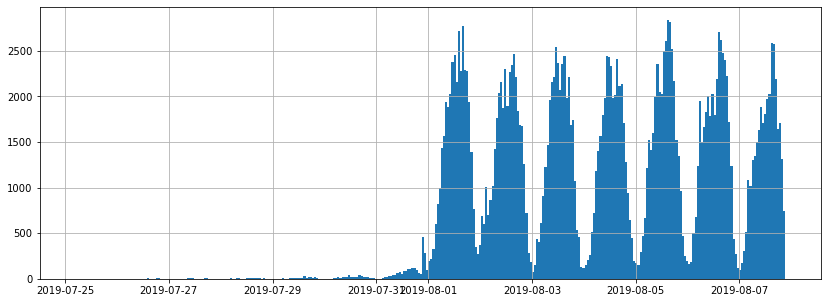

In [13]:
# проверяю, временные гарницы 
display(data['event_time'].min())
display(data['event_time'].max())
data['event_time'].hist(bins=14*24, figsize=(14, 5))

In [14]:
# проверяю количество событий до 1.08.2019
display('Количество событий:', len(data[data['date'] < '2019-8-1']))
display('Доля событий июля, %:', round(len(data[data['date'] < '2019-8-1']) / len(data['date']) * 100, 2))

'Количество событий:'

2826

'Доля событий июля, %:'

1.16

In [15]:
# исключаю неполные данные
data = data[data['date'] > '2019-7-31']

In [16]:
# проверяю количество "потерянных" пользователей
display('Количество исключенных пользователей:', row_ucer_cnt - data['user_id'].nunique())
display('Доля исключенных пользователей, %:', 
       round((row_ucer_cnt - data['user_id'].nunique()) / row_ucer_cnt * 100, 2))

'Количество исключенных пользователей:'

17

'Доля исключенных пользователей, %:'

0.23

In [17]:
# проверяю, все ли экспериментальные группы представлены
data['group'].value_counts()

248    84563
246    79302
247    77022
Name: group, dtype: int64

### Итоги проверки данных
В ходе изучения и проверки данных выявлено:
* данные представленны по всем трем группам эксперимента
* в период с 25.07.2019 по 7.08.2019 включительно приложением пользовались 7551 человек
* зарегистрировано 243713 событий 5-ти типов
* количество событий июля (с 25.07.2019 по 31.07.2019) - 2826, это 1.16% от общего объема
* 17 уникальных пользователей, 0.23% от общего числа, не совершили ни одного действия в августе
 
Из дальнейшего исследования исключены события июля и пользователи, которые не проявили себя в августе.

## Изучение воронки событий

In [18]:
# проверяю события и их частоту
data['event'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event, dtype: int64

In [19]:
# считаю количество пользователей по событиям и их долю от общего числа
event_by_user = (data.pivot_table(index='event', values='user_id', aggfunc='nunique')
                 .sort_values(by='user_id', ascending=False)).reset_index()
event_by_user.columns = ['event', 'user_cnt']
event_by_user['cr'] = (event_by_user['user_cnt'] / data['user_id'].nunique() * 100).round()
event_by_user

,event,user_cnt,cr
0,MainScreenAppear,7419,98.0
1,OffersScreenAppear,4593,61.0
2,CartScreenAppear,3734,50.0
3,PaymentScreenSuccessful,3539,47.0
4,Tutorial,840,11.0


In [20]:
# считаю конверсию из шага в шаг
event_by_user['cr_to_step'] = (event_by_user['user_cnt'] / event_by_user['user_cnt'].shift(1) * 100).round()
event_by_user

,event,user_cnt,cr,cr_to_step
0,MainScreenAppear,7419,98.0,NaN
1,OffersScreenAppear,4593,61.0,62.0
2,CartScreenAppear,3734,50.0,81.0
3,PaymentScreenSuccessful,3539,47.0,95.0
4,Tutorial,840,11.0,24.0


### Результаты воронки событий 
В представленных логах встречается 5 видов событий:
* появление на главном экране,
* на экране с товаром,
* на экране корзины, 
* оплаты и 
* обучения.

Причем первые 4 события выстраиваются в последовательную цепочку.

Только 11% пользователей использует подсказки по использованию приложения, а до покупки доходит лишь 47% аудитории, при том, что почти все, кто проверил товары в корзине, дошли до покупки (95%). Чуть уступает конверсия из просмотра товара в добавление его в корзину (81%), а это 50% от общего потока пользователей. А вот на этапе перехода с главного экрана к странице с выбором товара пользователи теряются, знакомятся с предложениями товаров только 61% от общего числа (62% от тех, кто попал на главный экран).

Таким образом главная зона роста - привлечь пользователей с главной страницы к выбору товаров.

## Изучение результатов эксперимента

In [21]:
# считаю количество пользователей по группам
data.groupby('group').agg({'user_id': 'nunique'})

,user_id
group,
246,2484
247,2513
248,2537


In [22]:
# разделяю датасет на отдельные группы
group_246 = data[data['group'] == 246]
group_247 = data[data['group'] == 247]
group_248 = data[data['group'] == 248]

*Гипотезы:*

* H0: различий в среднем количестве событий между группами 246 и 247 нет.
* H1: различия в среднем количестве событий между группами 246 и 247 есть.

In [23]:
# считаю количество событий по дням в каждой группе
ev_cnt_246 = group_246.groupby('date').agg({'event': 'count'})
ev_cnt_247 = group_247.groupby('date').agg({'event': 'count'})

# создаю списки событий по дням
sample_246 = ev_cnt_246['event']
sample_247 = ev_cnt_247['event']

# считаю статистическую значимость различий в количестве событий по группам
display('p-value:', "{0:.3f}".format(stats.mannwhitneyu(sample_246, sample_247)[1]))

'p-value:'

'0.620'

*Вывод:* значение p-value больше 0.05, значит нет оснований отвергнуть нулевую гипотезу, различий в среднем количестве событий между контрольными группами нет.

In [24]:
# создаю функцию для проверки равенства долей
def get_p_value(event_gr_a, event_gr_b, group_a, group_b):
    users_in_event = np.array([event_gr_a, event_gr_b]) # число пользователей, совершивших это событие
    users_in_group = np.array([group_a, group_b]) # число пользователей в группе
    # пропорция успехов в первой группе:
    p1 = users_in_event[0]/users_in_group[0]
    # пропорция успехов во второй группе:
    p2 = users_in_event[1]/users_in_group[1]
    # пропорция успехов в комбинированном датасете:
    p_combined = (users_in_event[0] + users_in_event[1]) / (users_in_group[0] + users_in_group[1])
    # разница пропорций в датасетах
    difference = p1 - p2
    # считаею статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/users_in_group[0] + 1/users_in_group[1]))
    # задаю стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

*Гипотезы:*

* H0: доли уникальных посетителей, побывавших на этапе воронки, одинаковы.
* H1: между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница.

In [25]:
# критический уровень статистической значимости
alpha = 0.05

In [26]:
# проверяю равенство долей групп 246 и 247 по событию MainScreenAppear
display('Событие MainScreenAppear', 'p-value:', '{0:.5f}'.format(
    get_p_value(group_246[group_246['event'] == 'MainScreenAppear']['user_id'].nunique(),
                group_247[group_247['event'] == 'MainScreenAppear']['user_id'].nunique(),
                group_246['user_id'].nunique(),
                group_247['user_id'].nunique())))

'Событие MainScreenAppear'

'p-value:'

'0.75706'

In [27]:
# проверяю равенство долей групп 246 и 247 по событию OffersScreenAppear 
display('Событие OffersScreenAppear', 'p-value:', '{0:.5f}'.format(
    get_p_value(group_246[group_246['event'] == 'OffersScreenAppear']['user_id'].nunique(),
                group_247[group_247['event'] == 'OffersScreenAppear']['user_id'].nunique(),
                group_246['user_id'].nunique(),
                group_247['user_id'].nunique())))

'Событие OffersScreenAppear'

'p-value:'

'0.24810'

In [28]:
# проверяю равенство долей групп 246 и 247 по событию CartScreenAppear
display('Событие CartScreenAppear', 'p-value:', '{0:.5f}'.format(
    get_p_value(group_246[group_246['event'] == 'CartScreenAppear']['user_id'].nunique(),
                group_247[group_247['event'] == 'CartScreenAppear']['user_id'].nunique(),
                group_246['user_id'].nunique(),
                group_247['user_id'].nunique())))

'Событие CartScreenAppear'

'p-value:'

'0.22883'

In [29]:
# проверяю равенство долей групп 246 и 247 по событию PaymentScreenSuccessful
display('Событие PaymentScreenSuccessful', 'p-value:', '{0:.5f}'.format(
    get_p_value(group_246[group_246['event'] == 'PaymentScreenSuccessful']['user_id'].nunique(),
                group_247[group_247['event'] == 'PaymentScreenSuccessful']['user_id'].nunique(),
                group_246['user_id'].nunique(),
                group_247['user_id'].nunique())))

'Событие PaymentScreenSuccessful'

'p-value:'

'0.11457'

In [30]:
# проверяю равенство долей групп 246 и 247 по событию Tutorial
display('Событие Tutorial', 'p-value:', '{0:.5f}'.format(
    get_p_value(group_246[group_246['event'] == 'Tutorial']['user_id'].nunique(),
                group_247[group_247['event'] == 'Tutorial']['user_id'].nunique(),
                group_246['user_id'].nunique(),
                group_247['user_id'].nunique())))

'Событие Tutorial'

'p-value:'

'0.93770'

In [31]:
# объединенная контрольная группа А+А
group_246_247 = data[data['group'] != 248]

In [32]:
# проверка равенства долей уникальных посетителей, побывавших на этапе воронки
# создаю таблицу с количеством пользователей по группам на событие
funnel = data.pivot_table(index='event', columns='group', values='user_id', aggfunc='nunique').reset_index()
funnel = funnel.rename(columns={246: 'group_246', 247: 'group_247', 248: 'group_248'})
funnel['246_and_247'] = funnel['group_246'] + funnel['group_247']
display(funnel.sort_values(by='group_246', ascending=False))
# переменные с количеством пользователей в группе
total_246 = group_246['user_id'].nunique()
total_247 = group_247['user_id'].nunique()
total_248 = group_248['user_id'].nunique()
total_246_247 = group_246_247['user_id'].nunique()
# проверяю равенство долей
# MainScreenAppear
display('Событие MainScreenAppear, группы 246 и 248', 'p-value:',
        '{0:.3f}'.format(get_p_value(funnel.loc[1, 'group_246'], funnel.loc[1, 'group_248'],
                                     total_246, total_248)))

display('Событие MainScreenAppear, группы 247 и 248', 'p-value:',
        '{0:.3f}'.format(get_p_value(funnel.loc[1, 'group_247'], funnel.loc[1, 'group_248'],
                                     total_247, total_248)))

display('Событие MainScreenAppear, группы 246+247 и 248', 'p-value:',
        '{0:.3f}'.format(get_p_value(funnel.loc[1, '246_and_247'], funnel.loc[1, 'group_248'],
                                     total_246_247, total_248)))
# OffersScreenAppear
display('Событие OffersScreenAppear, группы 246 и 248', 'p-value:',
        '{0:.3f}'.format(get_p_value(funnel.loc[2, 'group_246'], funnel.loc[2, 'group_248'],
                                     total_246, total_248)))

display('Событие OffersScreenAppear, группы 247 и 248', 'p-value:',
        '{0:.3f}'.format(get_p_value(funnel.loc[2, 'group_247'], funnel.loc[2, 'group_248'],
                                     total_247, total_248)))

display('Событие OffersScreenAppear, группы 246+247 и 248', 'p-value:',
        '{0:.3f}'.format(get_p_value(funnel.loc[2, '246_and_247'], funnel.loc[2, 'group_248'],
                                     total_246_247, total_248)))
# CartScreenAppear
display('Событие CartScreenAppear, группы 246 и 248', 'p-value:',
        '{0:.3f}'.format(get_p_value(funnel.loc[0, 'group_246'], funnel.loc[0, 'group_248'],
                                     total_246, total_248)))

display('Событие CartScreenAppear, группы 247 и 248', 'p-value:',
        '{0:.3f}'.format(get_p_value(funnel.loc[0, 'group_247'], funnel.loc[0, 'group_248'],
                                     total_247, total_248)))

display('Событие CartScreenAppear, группы 246+247 и 248', 'p-value:',
        '{0:.3f}'.format(get_p_value(funnel.loc[0, '246_and_247'], funnel.loc[0, 'group_248'],
                                     total_246_247, total_248)))
# PaymentScreenSuccessful
display('Событие CartScreenAppear, группы 246 и 248', 'p-value:',
        '{0:.3f}'.format(get_p_value(funnel.loc[3, 'group_246'], funnel.loc[3, 'group_248'],
                                     total_246, total_248)))

display('Событие PaymentScreenSuccessful, группы 247 и 248', 'p-value:',
        '{0:.3f}'.format(get_p_value(funnel.loc[3, 'group_247'], funnel.loc[3, 'group_248'],
                                     total_247, total_248)))

display('Событие PaymentScreenSuccessful, группы 246+247 и 248', 'p-value:',
        '{0:.3f}'.format(get_p_value(funnel.loc[3, '246_and_247'], funnel.loc[3, 'group_248'],
                                     total_246_247, total_248)))
# Tutorial
display('Событие Tutorial, группы 246 и 248', 'p-value:',
        '{0:.3f}'.format(get_p_value(funnel.loc[4, 'group_246'], funnel.loc[4, 'group_248'],
                                     total_246, total_248)))

display('Событие Tutorial, группы 247 и 248', 'p-value:',
        '{0:.3f}'.format(get_p_value(funnel.loc[4, 'group_247'], funnel.loc[4, 'group_248'],
                                     total_247, total_248)))

display('Событие Tutorial, группы 246+247 и 248', 'p-value:',
        '{0:.3f}'.format(get_p_value(funnel.loc[4, '246_and_247'], funnel.loc[4, 'group_248'],
                                     total_246_247, total_248)))

group,event,group_246,group_247,group_248,246_and_247
1,MainScreenAppear,2450,2476,2493,4926
2,OffersScreenAppear,1542,1520,1531,3062
0,CartScreenAppear,1266,1238,1230,2504
3,PaymentScreenSuccessful,1200,1158,1181,2358
4,Tutorial,278,283,279,561


'Событие MainScreenAppear, группы 246 и 248'

'p-value:'

'0.295'

'Событие MainScreenAppear, группы 247 и 248'

'p-value:'

'0.459'

'Событие MainScreenAppear, группы 246+247 и 248'

'p-value:'

'0.294'

'Событие OffersScreenAppear, группы 246 и 248'

'p-value:'

'0.208'

'Событие OffersScreenAppear, группы 247 и 248'

'p-value:'

'0.920'

'Событие OffersScreenAppear, группы 246+247 и 248'

'p-value:'

'0.434'

'Событие CartScreenAppear, группы 246 и 248'

'p-value:'

'0.078'

'Событие CartScreenAppear, группы 247 и 248'

'p-value:'

'0.579'

'Событие CartScreenAppear, группы 246+247 и 248'

'p-value:'

'0.182'

'Событие CartScreenAppear, группы 246 и 248'

'p-value:'

'0.212'

'Событие PaymentScreenSuccessful, группы 247 и 248'

'p-value:'

'0.737'

'Событие PaymentScreenSuccessful, группы 246+247 и 248'

'p-value:'

'0.600'

'Событие Tutorial, группы 246 и 248'

'p-value:'

'0.826'

'Событие Tutorial, группы 247 и 248'

'p-value:'

'0.765'

'Событие Tutorial, группы 246+247 и 248'

'p-value:'

'0.765'

In [33]:
# корректирую уровень значимости для уменьшения FWER
# критический уровень статистической значимости
alpha = 0.05
# произведено 20 сравнений
bonferroni_alpha = alpha / 20  
bonferroni_alpha

0.0025

### Результаты эксперимента

Эксперементальные группы представлены следующим количеством пользователей:
* группа 246 - 2484 человек
* группа 247 - 2513 человек
* группа 248 - 2537 человек

Учитывая, что проведена множественная проверка гипотез по одни и тем же данным, для избежания ложноположительного результата изначально заданный 5% уровень значимости был откорректирован методом Бонферрони. Статистически значимых различий в среднем количестве событий между контрольными группами 246 и 247 нет, как нет различий в конверсии по событиям между этими группами. И также нет статистических значимых различий в долях посетителей, побывавших на разных этапах воронки, при сравнении экспериментальной группы с каждой контрольной по отдельности или с объединенной контрольной группой.

## Выводы
В ходе исследования поведения пользователей мобильного приложения стартапа, который продаёт продукты питания, была проведена предварительная обработка данных - удалены дубликаты, типы и названия приведены к подходящим форматам. В исследование попали действия более 7.5 тысяч пользователей, разделенных на 3 группы. Сроком для исследования определен период с 1 августа 2019 по 7 августа 2019 включительно. Наблюдения велись по 5 разным этапам, которые могут проходить пользователи приложения.

Воронка продаж показала, что 61% пользователей переходят к выбору товара, кладут товар в корзину 50% и оплачивают 47% от всех пользователей. В первую очередь потенциал роста кроется в увеличении конверсии с главной страницы к выбору продаваемых продуктов.

Результаты A/A/B-эксперимента не выявили статистически значимых различий в долях посетителей, побывавших на разных этапах воронки при множественном сравнении.